# Tutorial on Speech

In this tutorial we will investigate the representation of speech using audio signals and spectrograms, before making use of trained speech to text models. Finally we will make use of text to speech models to generate new audio.

## 1.0 Representing Audio Signals
In this section we will investigate audio signals and their various representations. (This part of the tutorial is based on code written by Dr Vincenzo Scotti.)

### 1.1 Loading and Visualising a Signal

We'll start by loading the audio signal in the WAV file that came with the tutorial. Upload the file to Google colab and then load it as follows:

In [2]:
import librosa

file_path = 'audio.wav'
audio, sr = librosa.load(file_path, sr=16000)
audio

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We see that the audio signal is just a big array of floats, repersenting a time series of pressure values. The librosa library that we used to load the signal has resampled the signal at a sampling rate we specified with the parameter 'sr'.

We can visualise the time series as a graph:

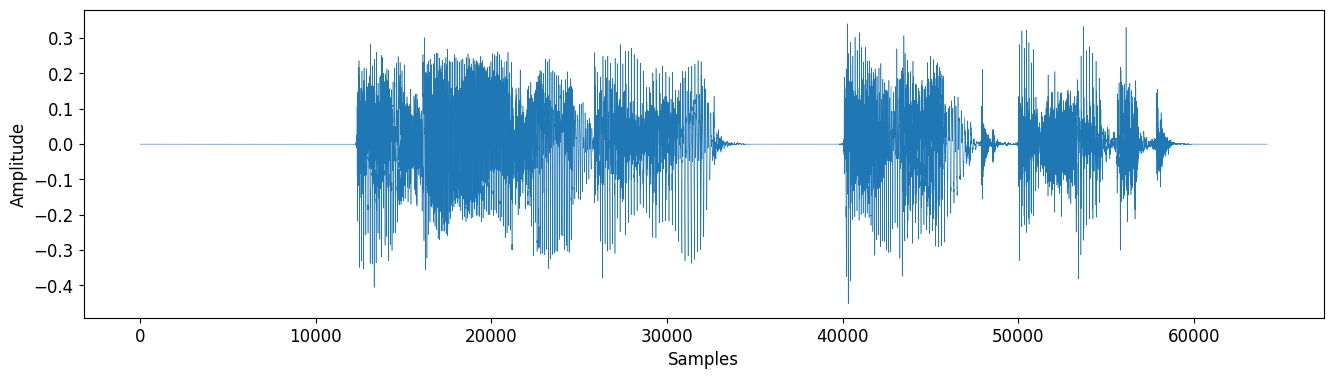

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 12}) ## make the font of the axes ticks/labels a bit bigger

fig = plt.figure(figsize=(16,4))
plt.plot(audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

We see a typical time series for speech.
The x-axis is the sample and the y-axis is the amplitude of the signal.

We can change the x-axis to be time once we know the duration of the time series, which we can get as follows:

In [4]:
duration = librosa.get_duration(y=audio, sr=sr)
duration

4.0106875

So the audio clip runs for just over 4 seconds.

We can now regenerate the graph with the x-axis being time in seconds:

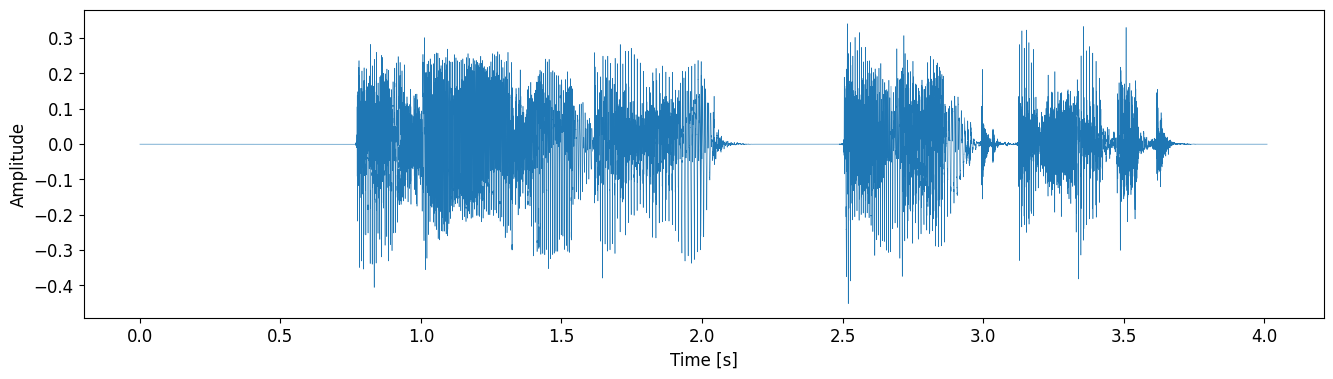

In [5]:
import numpy as np
num_samples = audio.shape[0]
time = np.linspace(0, duration, num_samples)

fig = plt.figure(figsize=(16,4))
plt.plot(time, audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.show()

We can listen to the audio signal in colab as follows:

In [6]:
from IPython.display import Audio
Audio(audio, rate=sr)

Credit goes to Dr Vincenzo Scotti for the choice of the audio clip ;-)

### 1.2 Representing the signal in the Frequency domain

When representing audio signals we often convert them to the frequency domain using the Fast Fourier Transform algorithm. We'll do that now to have a look at the signal in terms of its frequencies. (Note we'll take a small slice of the signal to do this.)

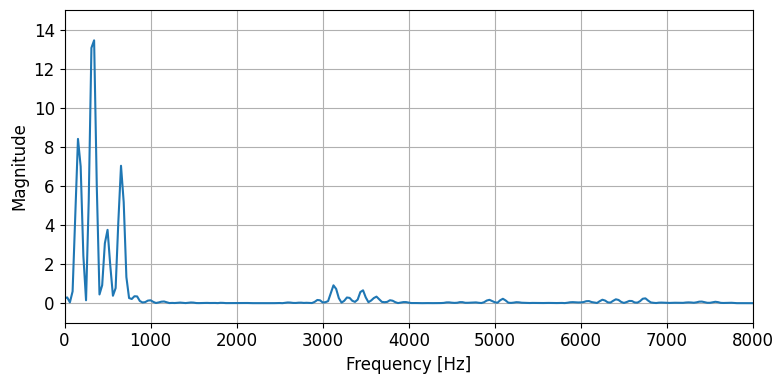

In [7]:
import math

w = int(math.ceil(0.025 * sr)) # use a window of size 25ms
d = int(math.ceil(0.01 * sr)) # and a delay between consecutive windows of 10ms
t = int(math.ceil(1.2 * sr))

n_fft = 512 # use a Fast Fourier transform of size 512 samples
spec = librosa.stft(y=audio, n_fft=n_fft, win_length=w, hop_length=d,)
freq = np.linspace(0,sr/2,spec.shape[0])
s = int(math.ceil(t/d))

fig = plt.figure(figsize=(8,4))
plt.plot(freq, np.abs(spec)[:, s])
plt.ylabel('Magnitude')
plt.xlabel('Frequency [Hz]')
plt.xlim([freq[0], freq[-1]])
plt.ylim([-1, 15])
plt.grid()
plt.tight_layout()
plt.show()

Typically we represent the importance of each frequency by the number of decibells, which is related to the logarithm of the amplitute of each frequency, (more precisily it is 10 times the logarithm of the squared amplitude of the signal, which is the engergy of the signal).

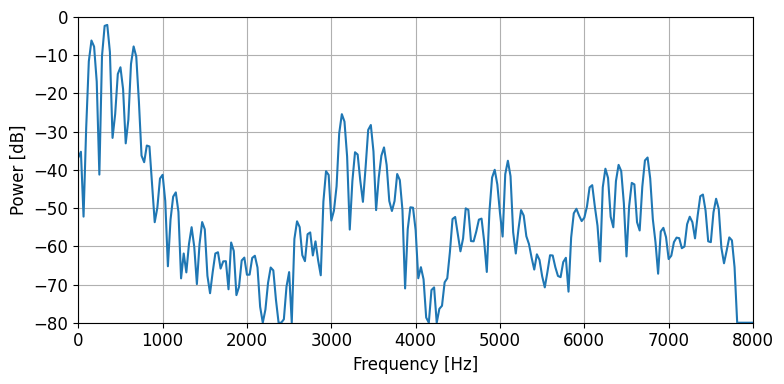

In [8]:
fig = plt.figure(figsize=(8,4))
plt.plot(freq, librosa.power_to_db(np.abs(spec) ** 2, ref=np.max)[:, s])
plt.ylabel('Power [dB]')
plt.xlabel('Frequency [Hz]')
plt.xlim([freq[0], freq[-1]])
plt.ylim([-80, 0])
plt.grid()
plt.tight_layout()
plt.show()

Note that the higher frequency components of the signal are then highlighted by the decibel conversion.

Speech consists of many different sounds one after another. So the typical representation of a speech signal is to divide the original signal up into short overlapping segments and then calculate the frequency distribution for each. Each segment is usually smoothed with a (Hann) windowing function. We can visualise this process as follows. First let's define the window size, delay and start time:

In [9]:
import math

w = int(math.ceil(0.025 * sr)) # use a window of size 25ms
d = int(math.ceil(0.01 * sr)) # and a delay between consecutive windows of 10ms
t = int(math.ceil(1.2 * sr)) # start at 1.2 seconds into the signal

Now let's plot a small segment of the audio signal with the windowing applied:

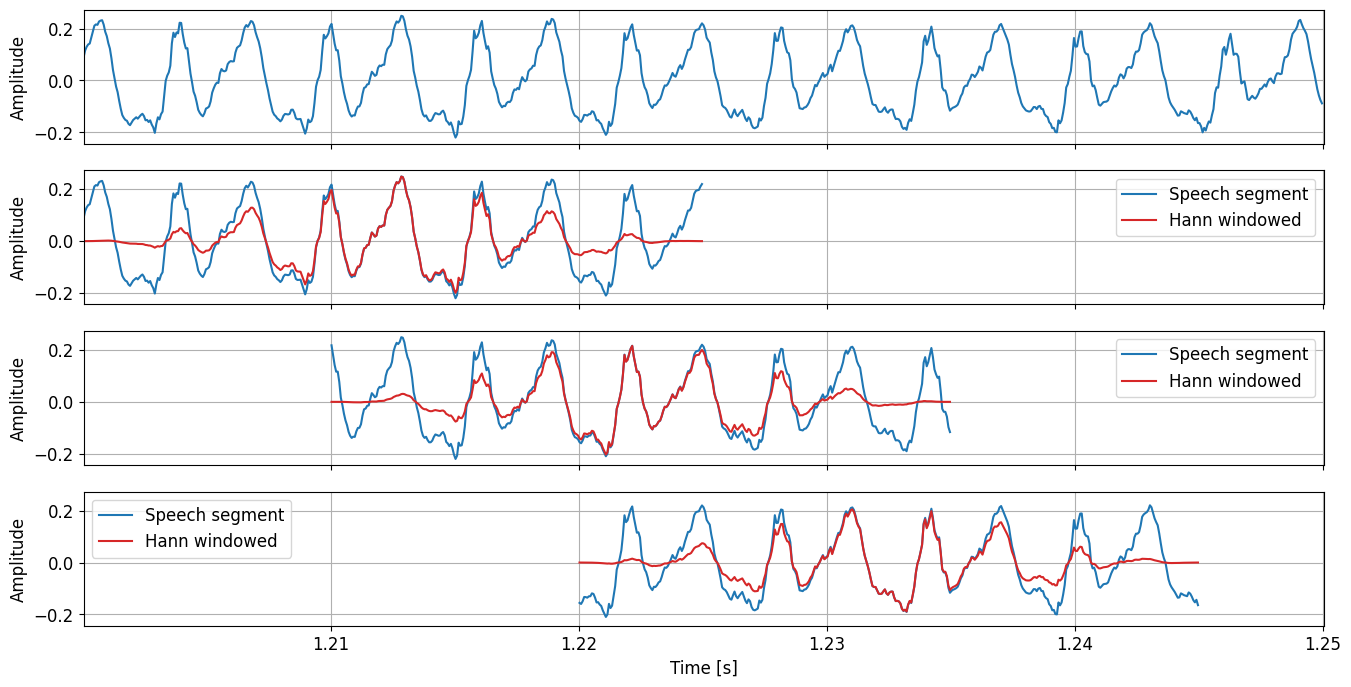

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 8), sharex=True, sharey=True)
axes[0].plot(time[t:t+(2*w)], audio[t:t+(2*w)])
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([time[t], time[t+(2*w)]])
axes[0].grid(True)

for i in range(3):
    axes[i + 1].plot(time[t+(i*d):t+(i*d)+w], audio[t+(i*d):t+(i*d)+w], c='tab:blue', label='Speech segment')
    axes[i + 1].plot(time[t+(i*d):t+(i*d)+w], audio[t+(i*d):t+(i*d)+w] * librosa.filters.get_window('hann', w), c='tab:red', label='Hann windowed')
    axes[i + 1].set_ylabel('Amplitude')
    axes[i + 1].grid(True)
    axes[i + 1].legend(loc='best')

axes[3].set_xlabel('Time [s]')
plt.show()

Having seen the visualisation, and understanding the process by which a Spectrogram is created, we can now directly call a method that will create the Spectrogram.

In [11]:
n_fft = 512 # use a Fast Fourier transform of size 512 samples
spec = librosa.stft(y=audio, n_fft=n_fft, win_length=w, hop_length=d,)
spec.shape

(257, 402)

So we have not converted a one-dimensional time series (audio signal) into a 2 dimenionsional matrix (spectrogram).
We can visualise the spectrogram as follows:

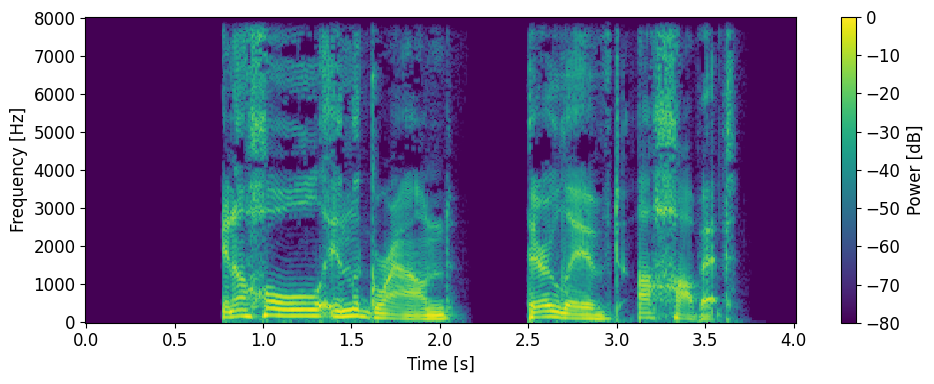

In [12]:
freq = np.linspace(0, sr / 2, spec.shape[0])
spec_time = np.linspace(0, duration, spec.shape[1])

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(spec_time, freq, librosa.power_to_db(np.abs(spec) ** 2, ref=np.max))
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.show()

### 1.3 The Mel spectrogram

The spectrogram shown above used a linear y-axis for the frequency dimension. We humans are sensitive to relative changes in pitch (which correspond to multiplicative changes in frequency) rather than absolute (additive) changes in the pitch.

So in Mel (short for melody) spectrogram, we transform the y-axis onto a logarithmic scale, using a mapping to compute mel frequencies as follows:

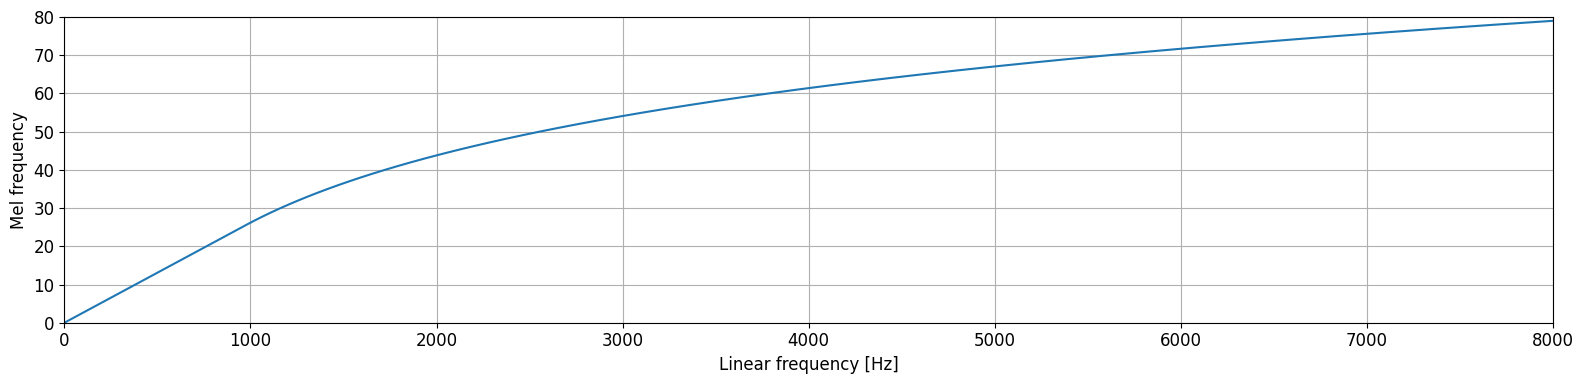

In [13]:
n_mel = 80
lin_freq = librosa.mel_frequencies(n_mels=n_mel, fmax=sr / 2)

fig = plt.figure(figsize=(16,4))
plt.plot(lin_freq, np.arange(n_mel))
plt.ylabel('Mel frequency')
plt.xlabel('Linear frequency [Hz]')
plt.xlim([0, lin_freq[-1]])
plt.ylim([0, 80])
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, win_length=w, hop_length=d, n_mels=n_mel)
mel_spec.shape

(80, 402)

In this way, when we plot the spectrogram the high frequencies are compressed and the lower frequencies expanded along the y-axis, such that the each step along the axis corresponds to the same multiplicative increase in the frequency:

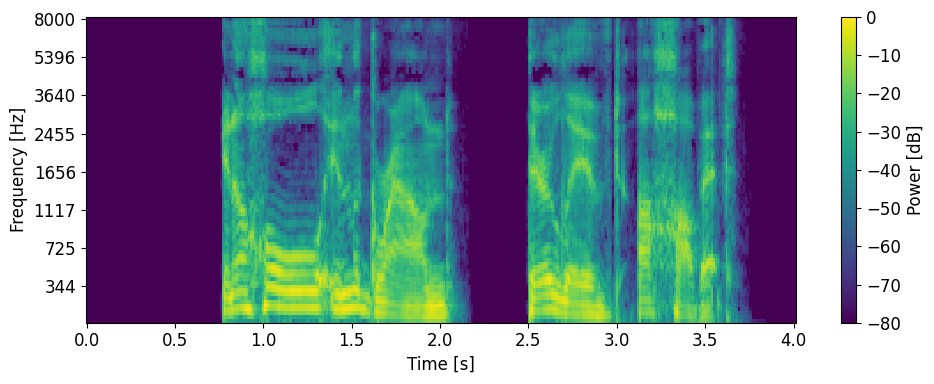

In [15]:
mel_comp = np.arange(mel_spec.shape[0]) + 1
mel_spec_time = np.linspace(0, duration, mel_spec.shape[1])

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel_spec_time, mel_comp, librosa.power_to_db(mel_spec, ref=np.max))
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks(ticks=mel_comp[9::10], labels=[f'{freq:.0f}' for freq in lin_freq[9::10]])
plt.tight_layout()
plt.show()

### 1.4 Record voice

Let's now record our own voice and create a Mel spectrogram from it.

To record audio we'll make use of code to from here: https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb

In [16]:
!pip install ffmpeg-python

In [17]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
# from google.colab.output import eval_js

from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [19]:
audio, sr = get_audio()

NameError: name 'eval_js' is not defined

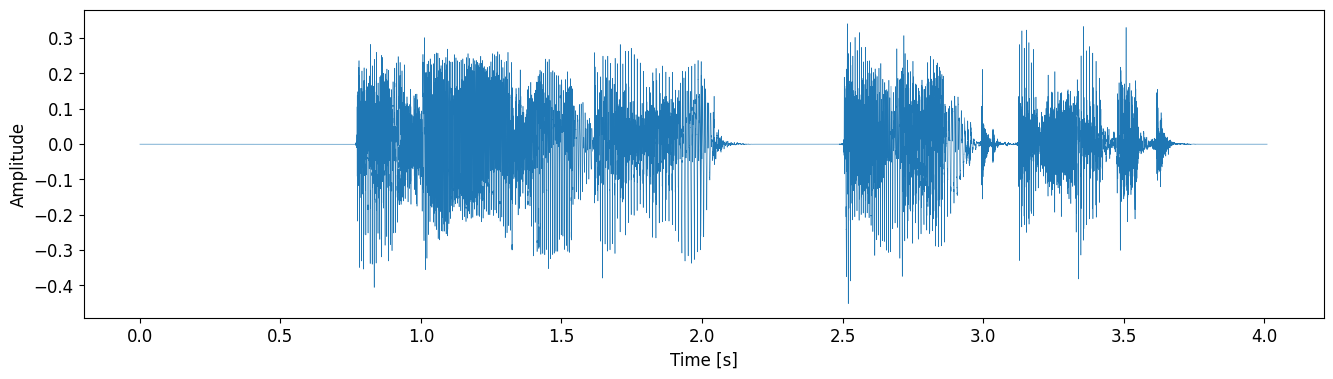

In [20]:
num_samples = audio.shape[0]
time = np.linspace(0, duration, num_samples)

fig = plt.figure(figsize=(16,4))
plt.plot(time, audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.show()

We can save this audio recording for later use ...

In [21]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

Copy code from above to generate the Mel Spectrogram for your own voice.

## 2.0 Speech Recognition

Now that we know how to represent audio signals in a way that highlights the different components of the speech, we can try to make use of techniques for recognising speech sounds in the signal.

We will make use of a state-of-the-art transformer-based speech recognition system from OpanAI called Whisper: https://github.com/openai/whisper



Let's first install the Python library:

In [22]:
!pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using c

Whisper models come pretrained with various model sizes. We will download one of the smaller models, called "base", which is only 139MB. Feel free to try a larger model!

In [23]:
import whisper

model = whisper.load_model("base")

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 114MiB/s]


Now that we have the model, we can use it for transcribing audio to text. Let's start with our original WAV file.

In [24]:
result = model.transcribe("audio.wav")
print(result["text"])

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 In a hole in the ground, they're lived a hobbit.


If you see a warning (about FP16 not being supported) just ignore it. It's because you are running Whisper on the CPU rather than a GPU, but there's no need for a GPU for the moment.

How did it go? Did it transcribe the text correctly?
(If not, why not, and what could be done about it?)

### 2.1 Detecting the spoken language

The model we downloaded for Whisper can transcribe text not only in English but in MANY languages.

As part of the functionality Whisper can detect the spoken language, so let's try it.

We will now follow the pipeline for processing the audio that was hidden from us when we directly called the "transcribe()" method above. The first step is to detect the speech in the audio signal and trim or pad the signal to a certain length (30 seconds):

In [26]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("audio.wav")
audio = whisper.pad_or_trim(audio)
audio

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

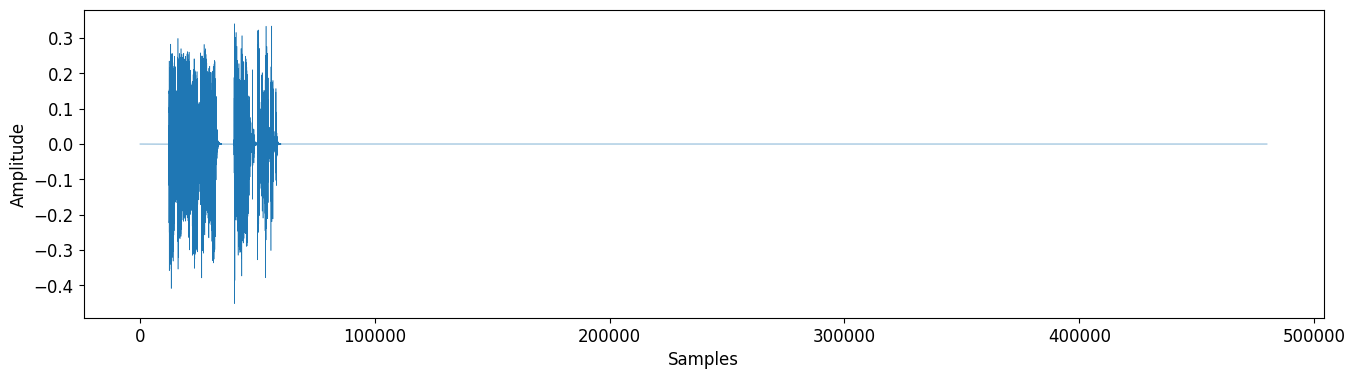

In [27]:
fig = plt.figure(figsize=(16,4))
plt.plot(audio, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

The next step is to compute the Mel Spectrogram:

In [28]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)
mel

tensor([[-0.8046, -0.8046, -0.8046,  ..., -0.8046, -0.8046, -0.8046],
        [-0.8046, -0.8046, -0.8046,  ..., -0.8046, -0.8046, -0.8046],
        [-0.8046, -0.8046, -0.8046,  ..., -0.8046, -0.8046, -0.8046],
        ...,
        [-0.8046, -0.8046, -0.8046,  ..., -0.8046, -0.8046, -0.8046],
        [-0.8046, -0.8046, -0.8046,  ..., -0.8046, -0.8046, -0.8046],
        [-0.8046, -0.8046, -0.8046,  ..., -0.8046, -0.8046, -0.8046]])

Let's visualise the spectrogram:

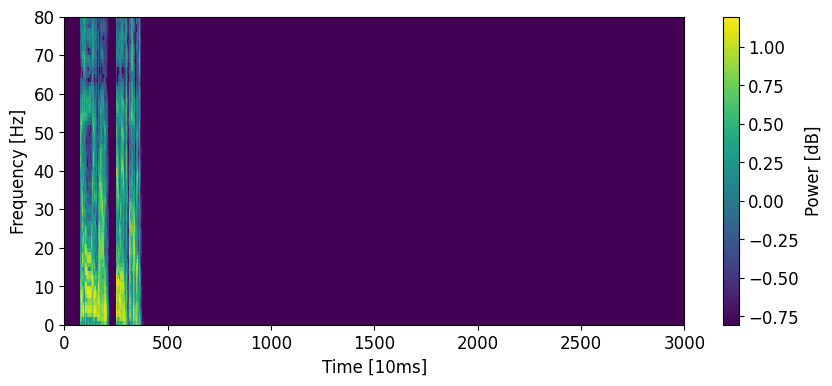

In [29]:
fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel.cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

Note that the signal has been padded out to 30 seconds.

Now let's use Whisper to detect the language based on the audio clip:

In [30]:
_, probs = model.detect_language(mel)
lang = max(probs, key=probs.get)
print(f"Detected language: {lang}, confidence: {probs[lang]}")


Detected language: en, confidence: 0.9960845708847046


So the model is pretty certain that the language is English!

Although it had quite a few languages to choose from. Have a look:

In [31]:
probs

{'fa': 4.710510438599158e-06,
 'ka': 1.0601023348044691e-07,
 'th': 5.498314931173809e-05,
 'hr': 7.77176751398656e-07,
 'bn': 3.319109737276449e-06,
 'ur': 4.152018391323509e-06,
 'gl': 1.0160947567783296e-06,
 'mi': 9.166301606455818e-05,
 'ar': 8.117796096485108e-05,
 'sd': 1.4626091626723792e-07,
 'uk': 3.2172249575523892e-06,
 'hy': 3.7760327131763916e-07,
 'cs': 7.084218850650359e-06,
 'br': 1.2170406989753246e-05,
 'da': 7.827580702723935e-06,
 'lb': 1.4418661820059242e-08,
 'hu': 1.2137801604694687e-05,
 'eu': 8.224450880334189e-07,
 'as': 2.014780164927288e-08,
 'lo': 6.081461378926178e-07,
 'tg': 1.4006240611763587e-08,
 'sw': 1.625860704734805e-06,
 'tl': 1.4700683095725253e-05,
 'sl': 5.8730406635731924e-06,
 'af': 2.6295738280168734e-06,
 'bg': 9.102943181460432e-07,
 'kn': 9.875888906663022e-08,
 'ne': 2.831347956089303e-07,
 'he': 2.1093412215122953e-05,
 'cy': 0.000388415006455034,
 'su': 5.6163114159346605e-09,
 'pl': 0.00017412591842003167,
 'lv': 1.0454845096319332e-

Try loading the second audio sample from the tutorial "italiano.mp3" and see if the model can correctly determine the language.

In [32]:
audio2 = whisper.load_audio("italiano.mp3")

Audio(audio2, rate=sr)

What happened?? Try changing the sample rate (sr) to 16000. -- Whisper has resampled the audio at a new rate of 16kHz.

Any better?

In [33]:
Audio(audio2, rate=16000)

Now copy the code from above to predict the language:

Did it work? How confident was the model that the language was Italian?

Now we can try to transcribe the Italian audio:

In [39]:
audio2 = whisper.pad_or_trim(audio2)
mel = whisper.log_mel_spectrogram(audio2).to(model.device)

# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)


Sabato 18, alle ore 20 e 25, in telecronna cadireta da Wembley, in Gilterra Italia, valevole per la qualificazione della Copa del Mundo. Fantozi, avevo un programma formi d'abile.


In [41]:
_, probs = model.detect_language(mel)
lang = max(probs, key=probs.get)
print(f"Detected language: {lang}, confidence: {probs[lang]}")

Detected language: it, confidence: 0.9847943186759949


How good is Whisper at understanding Fantozzi?

### 2.2 Transcribing own audio

Try transcribing the audio that you produced before. Does it work?

In [42]:
result = model.transcribe("recording.wav")
print(result["text"])

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 In a hole in the ground, they're lived a hobbit.


## 3.0 Text to Speech


We'll make use of the Tacotron2 system following this notebook: https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/nvidia_deeplearningexamples_tacotron2.ipynb

To run the following code you will need to use a GPU, so change the runtime above to include one if you haven't already.

In [1]:
!pip install numpy scipy librosa unidecode inflect
#!apt-get update
#!apt-get install -y libsndfile1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.5 MB/s eta 0:00:00


Load the Tacotron model from Torchhub:

In [2]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

Tacotron is a "Spectrogram predictor". It has been trained to input a text (or phonetic sequence) and output a mel spectrogram. A Vocoder is then needed to convert the spectrogram into an audio signal. In our case we will make use of the Waveglow vocoder for this purpose: https://github.com/NVIDIA/waveglow

Load the waveglow model as follows:

In [3]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

Now we have all we need. Let's write some text that we can use to generate the audio:

In [4]:
text = "Hello crazy world, I missed you so much."

That text is read in by the model and converted to a numeric sequence:

In [5]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])
sequences

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


tensor([[45, 42, 49, 49, 52, 11, 40, 55, 38, 63, 62, 11, 60, 52, 55, 49, 41,  6,
         11, 46, 11, 50, 46, 56, 56, 42, 41, 11, 62, 52, 58, 11, 56, 52, 11, 50,
         58, 40, 45,  7]], device='cuda:0')

### 3.1 Producing a Spectrogram

Now convert the sequence into a mel spectrogram with Tacotron2

In [6]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

We now have a spectrogram:

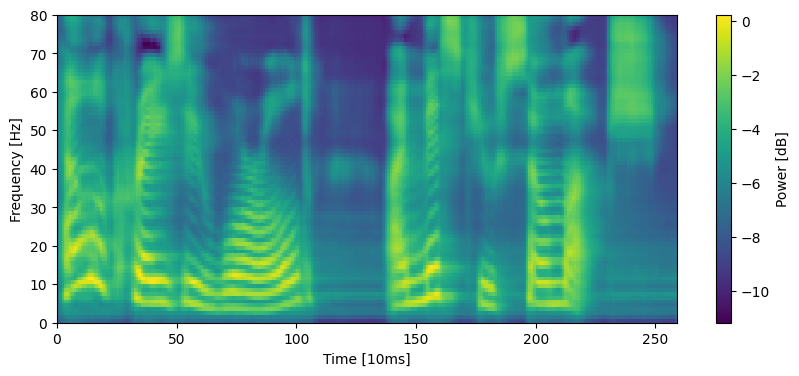

In [7]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel[0].cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

### 3.2 Producing Audio

Now use Waveglow to produce the audio signal

In [8]:
with torch.no_grad():
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050
audio_numpy

array([ 0.00015082, -0.00015307, -0.00057758, ..., -0.00155011,
       -0.00116877, -0.00056244], dtype=float32)

Have a look at the audio signal:

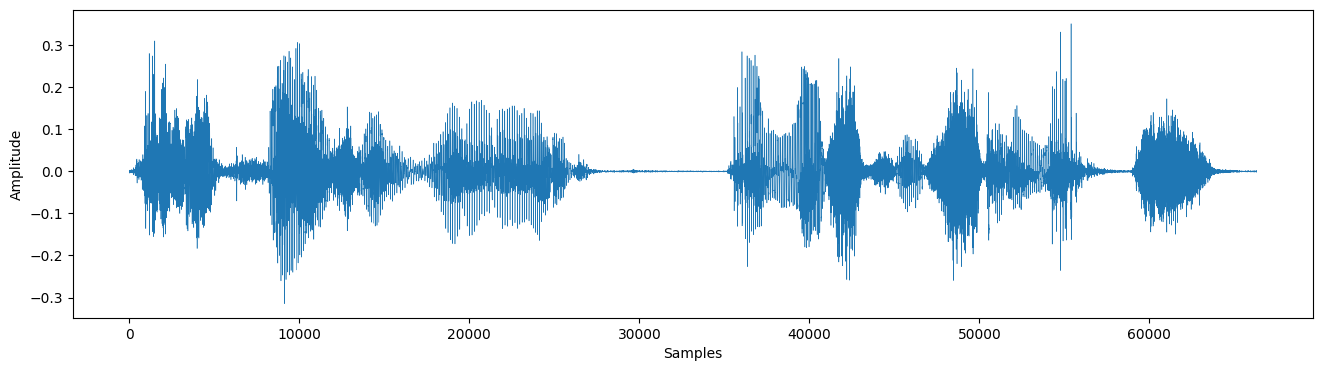

In [9]:
fig = plt.figure(figsize=(16,4))
plt.plot(audio_numpy, linewidth=0.4)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

Let's listen to it!

In [10]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)

Why not save the audio and see if the speech-to-text system can recognise it?

In [11]:
from scipy.io.wavfile import write
write("audio.wav", rate, audio_numpy)

Want to try to generate other types of voices? Check out this code from Vincenzo Scotti: https://github.com/vincenzo-scotti/tts_mellotron_api

The END. Hope you liked the Speech tutorial!